In [43]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

from scipy import spatial
#from pymongo import MongoClient
#from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.contrib.slim import conv2d, conv2d_transpose
from tensorflow.contrib.slim import fully_connected as fc

from ThemeSeacher import Updator, clean, PhraserModel, tokenizer
from ThemeSeacher import KeywordDict, Model, Extractor
from ThemeSeacher import EmbeddingModel, Clustering


# Pickle Functions

In [3]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


In [4]:
new_df = load_obj('new_embedding')

### Model

In [5]:
class VAE_2d(object):

    def __init__(self, n_z=2, learning_rate=1e-3, beta=100):
        self.learning_rate = learning_rate
        self.n_z = n_z
        self.beta = beta

        self.build()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, 100])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 100, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 64, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        f4 = fc(f3, 32, scope='enc_fc4', activation_fn=tf.nn.elu)
        f5 = fc(f4, 32, scope='enc_fc5', activation_fn=tf.nn.elu)
        f6 = fc(f5, 16, scope='enc_fc6', activation_fn=tf.nn.elu)
        f7 = fc(f6, 16, scope='enc_fc7', activation_fn=tf.nn.elu)
        f8 = fc(f7, 8, scope='enc_fc8', activation_fn=tf.nn.elu)
        f9 = fc(f8, 8, scope='enc_fc9', activation_fn=tf.nn.elu)
        f10 = fc(f9, 4, scope='enc_fc10', activation_fn=tf.nn.elu)
        self.z_mu = fc(f10, self.n_z, scope='enc_fc11_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f10, self.n_z, scope='enc_fc11_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=0.001, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 4, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 8, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 8, scope='dec_fc3', activation_fn=tf.nn.elu)
        g4 = fc(g3, 16, scope='dec_fc4', activation_fn=tf.nn.elu)
        g5 = fc(g4, 16, scope='dec_fc5', activation_fn=tf.nn.elu)
        g6 = fc(g5, 32, scope='dec_fc6', activation_fn=tf.nn.elu)
        g7 = fc(g6, 32, scope='dec_fc7', activation_fn=tf.nn.elu)
        g8 = fc(g7, 64, scope='dec_fc8', activation_fn=tf.nn.elu)
        g9 = fc(g8, 64, scope='dec_fc9', activation_fn=tf.nn.elu)
        g10 = fc(g9, 100, scope='dec_fc10', activation_fn=tf.nn.elu)
        self.x_hat = fc(g10, 100, scope='dec_fc11', activation_fn=None)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        #'''
        recon_loss = tf.reduce_mean(tf.squared_difference(self.x_hat, self.x))
        '''
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat),
            axis=1
        )
        #'''
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + self.beta * latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat

    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z
    
    def restore(self, saver, ckpt):
        saver.restore(self.sess, ckpt)

In [18]:
class VAE_conv(object):

    def __init__(self, n_z=2, learning_rate=1e-3, beta=100):
        self.learning_rate = learning_rate
        self.n_z = n_z
        self.beta = beta

        self.build()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, 100])

        # Encode
        # x -> z_mean, z_sigma -> z
        h = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.elu)
        # [bs, 8, 8, 4]
        h = tf.reshape(h, [-1, 8, 8, 4])
        # [bs, 8, 8, 4]
        h = conv2d(h, 4, [3, 3], scope='enc_conv1')
        # [bs, 4, 4, 8]
        h = conv2d(h, 8, [3, 3], stride=2, scope='enc_conv2')
        # [bs, 4, 4, 8]
        h = conv2d(h, 8, [3, 3], scope='enc_conv3')
        # [bs, 2, 2, 16]
        h = conv2d(h, 16, [3, 3], stride=2, scope='enc_conv4')
        
        h = tf.reshape(h, [-1, 64])
        
        self.z_mu = fc(h, self.n_z, scope='enc_fc2_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(h, self.n_z, scope='enc_fc2_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=0.001, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        h = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.elu)
        # [bs, 2, 2, 16]
        h = tf.reshape(h, [-1, 2, 2, 16])
        # [bs, 4, 4, 8]
        h = conv2d_transpose(h, 8, [3, 3], stride=2, scope='dec_conv2')
        # [bs, 4, 4, 8]
        h = conv2d_transpose(h, 8, [3, 3], stride=1, scope='dec_conv3')
        # [bs, 8, 8, 4]
        h = conv2d_transpose(h, 4, [3, 3], stride=2, scope='dec_conv4')
        # [bs, 8, 8, 4]
        h = conv2d_transpose(h, 4, [3, 3], stride=1, scope='dec_conv5')
        # [bs, 256]
        h = tf.reshape(h, [-1, 256])
        
        self.x_hat = fc(h, 100, scope='dec_fc2', activation_fn=None)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        #'''
        recon_loss = tf.reduce_mean(tf.squared_difference(self.x_hat, self.x))
        '''
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat),
            axis=1
        )
        #'''
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + self.beta * latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat

    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z
    
    def restore(self, saver, ckpt):
        saver.restore(self.sess, ckpt)

### Evaluation

In [115]:
model_name = 'final/mg2_200'

tf.reset_default_graph()
model = VAE_2d(n_z=4)
#model = VAE_conv(n_z=2)
saver = tf.train.Saver()
model.restore(saver, './ckpt/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt/final/mg2_200.ckpt


/home/qara/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


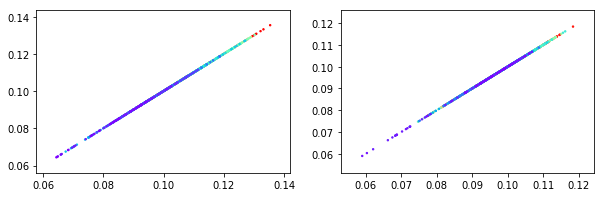

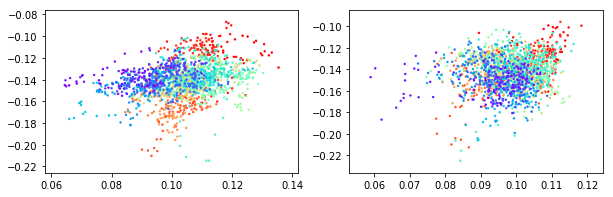

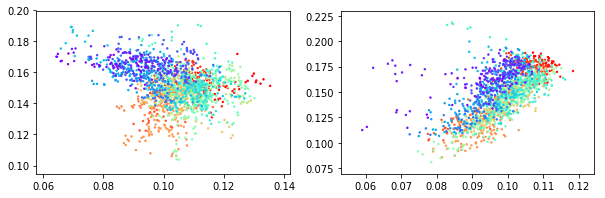

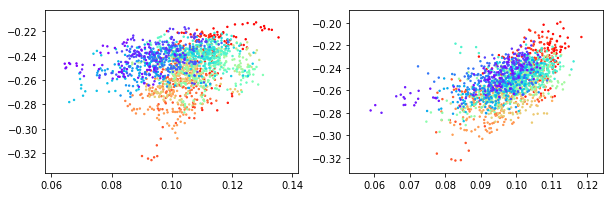

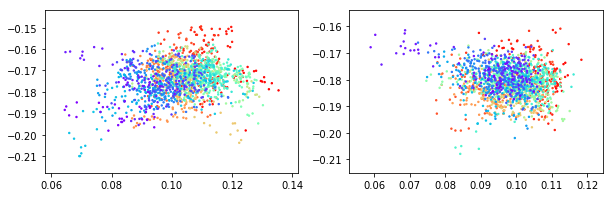

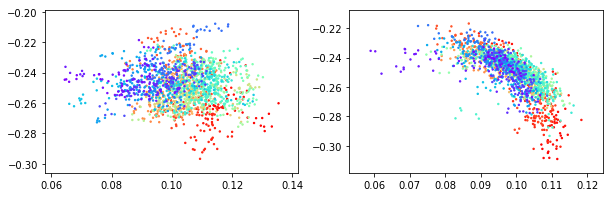

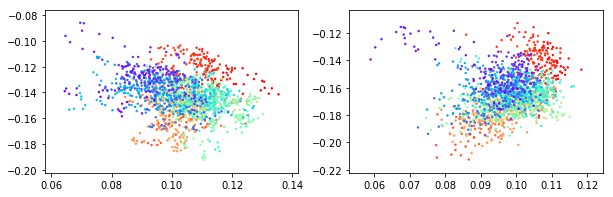

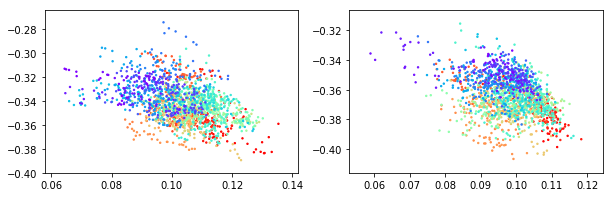

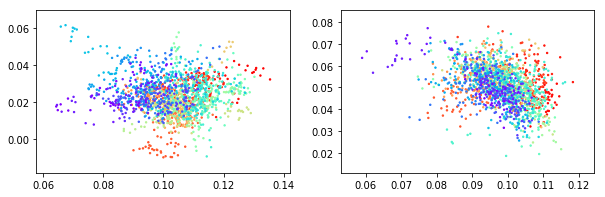

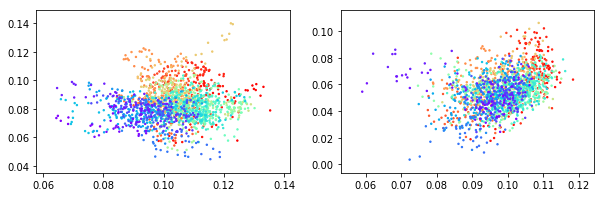

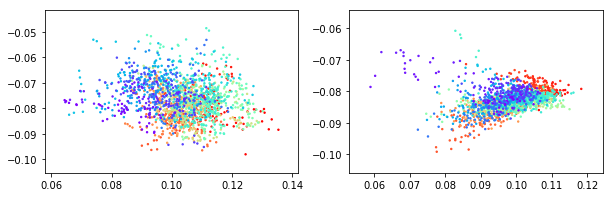

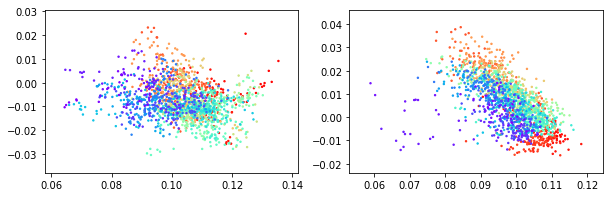

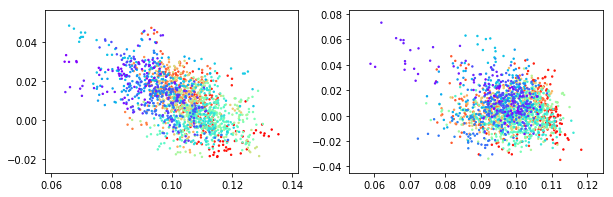

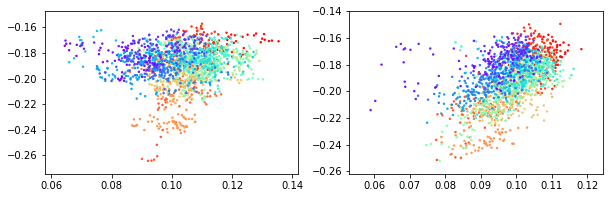

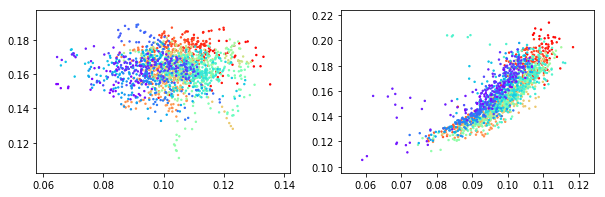

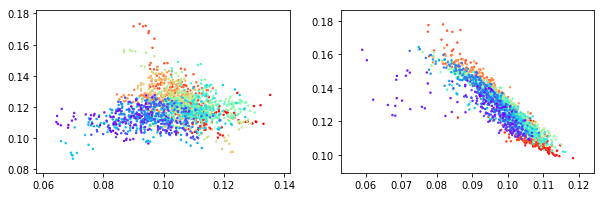

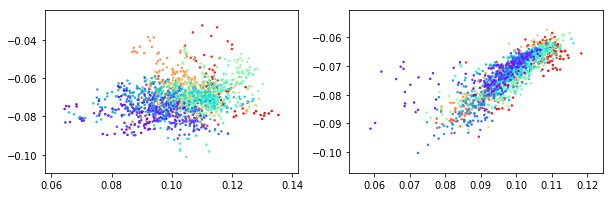

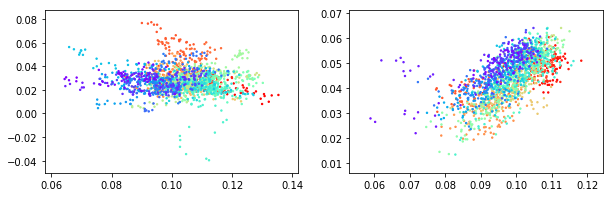

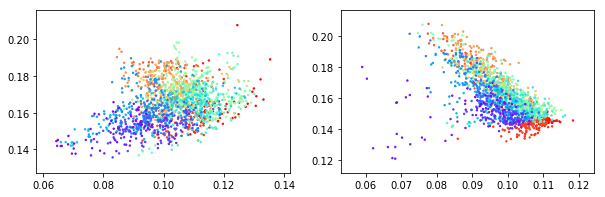

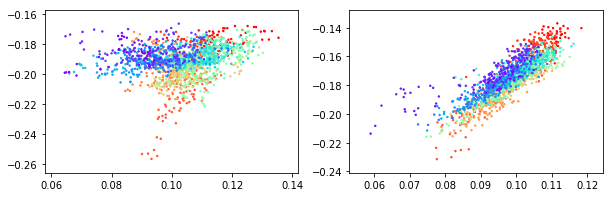

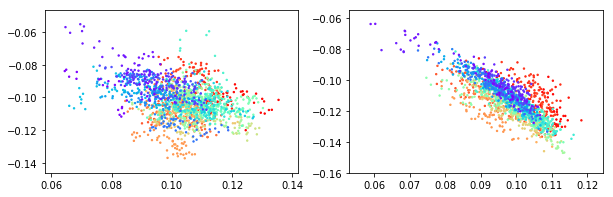

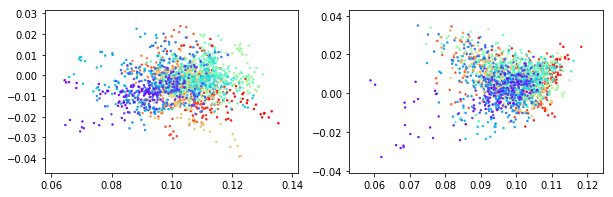

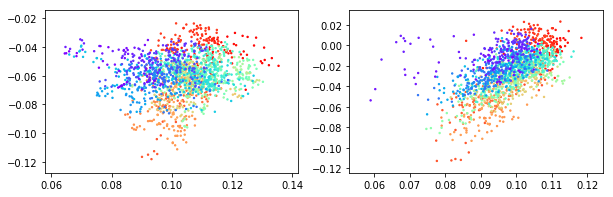

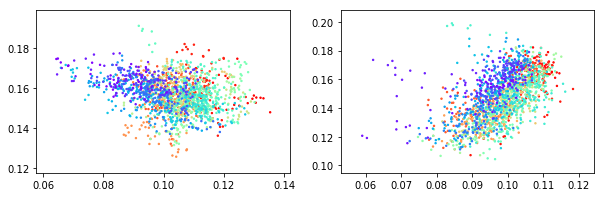

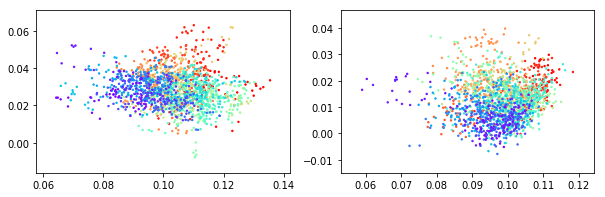

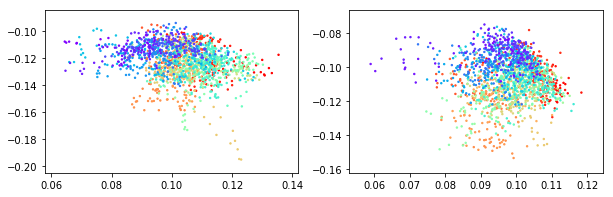

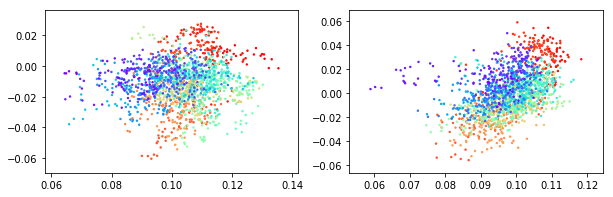

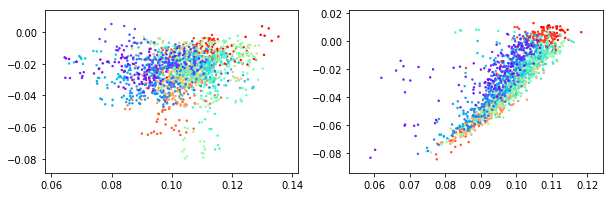

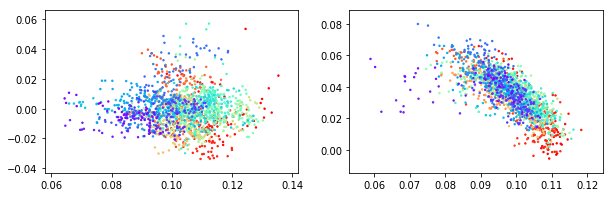

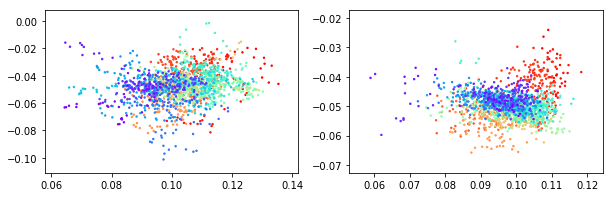

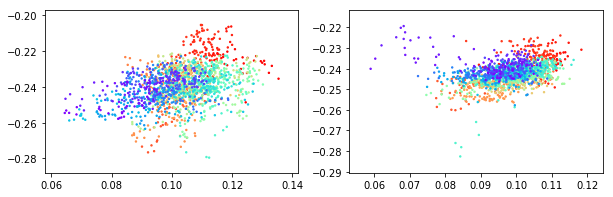

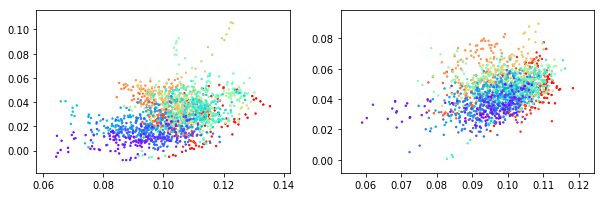

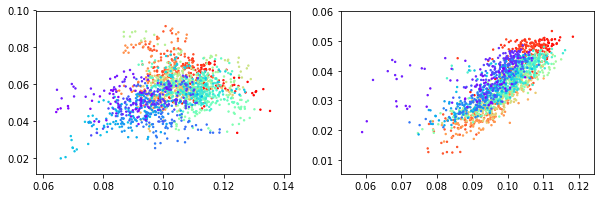

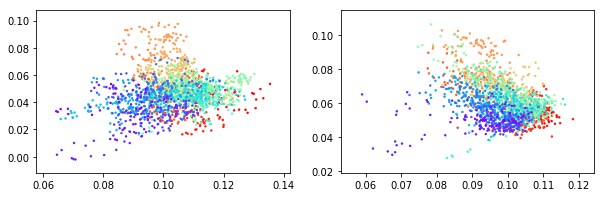

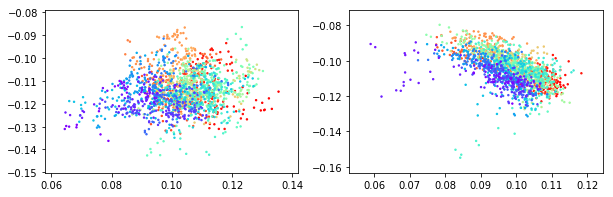

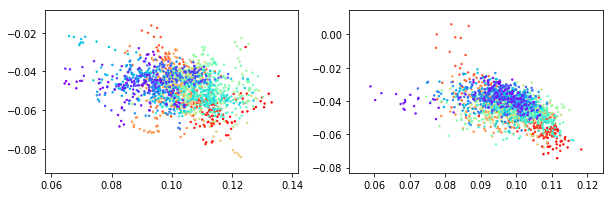

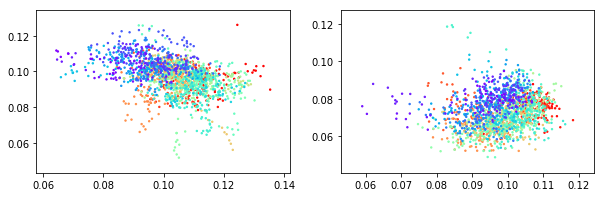

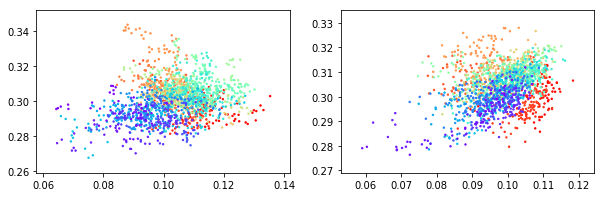

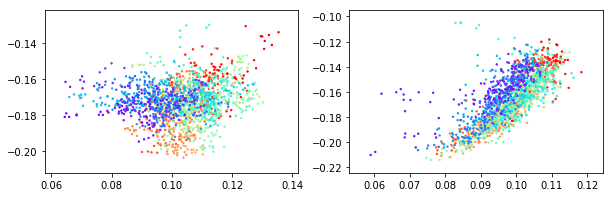

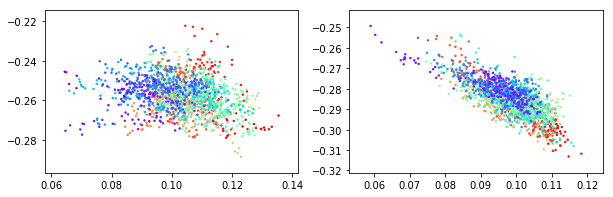

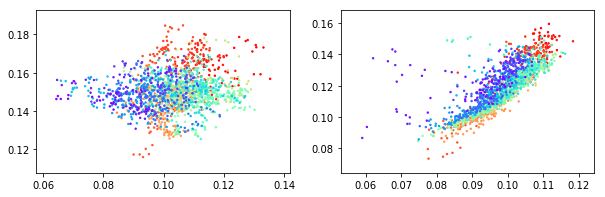

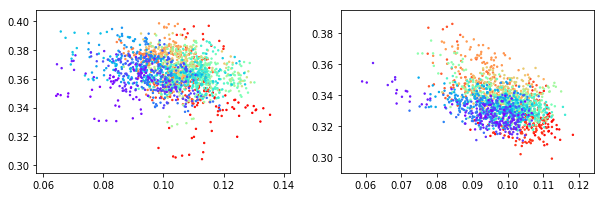

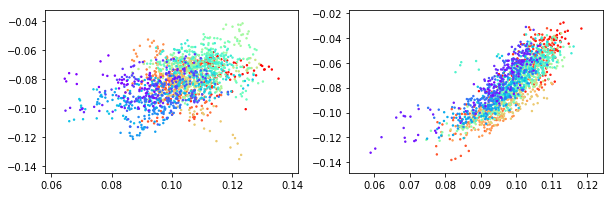

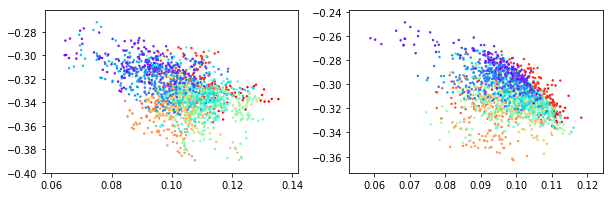

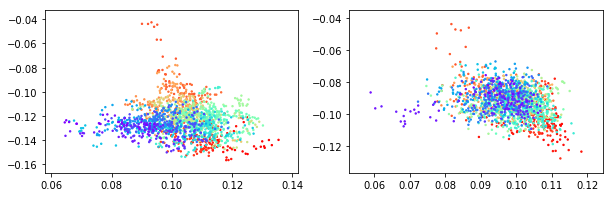

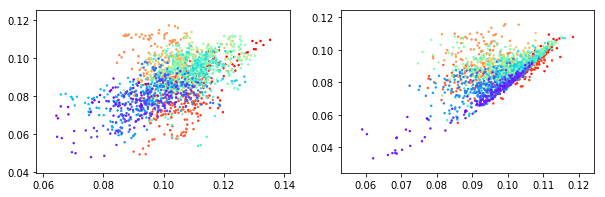

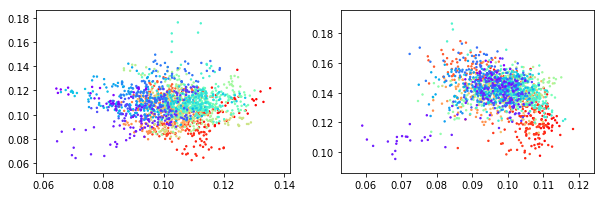

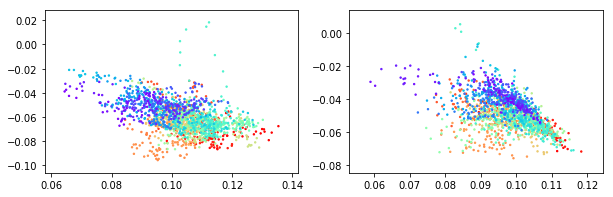

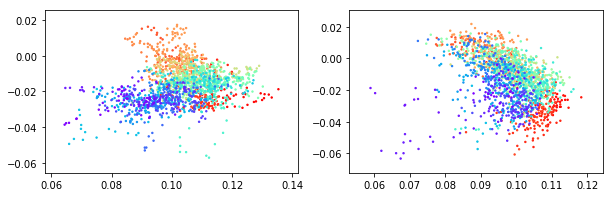

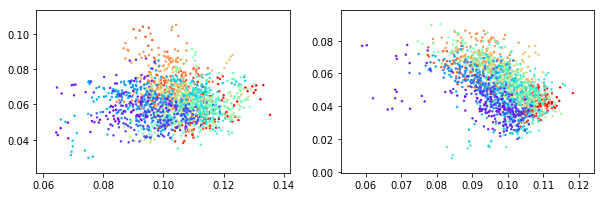

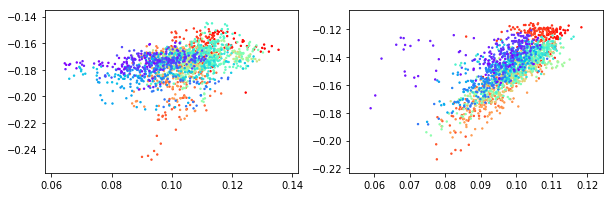

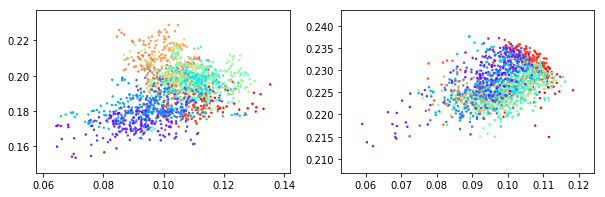

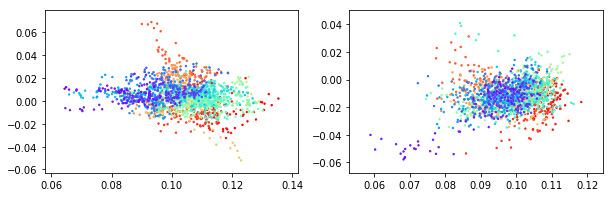

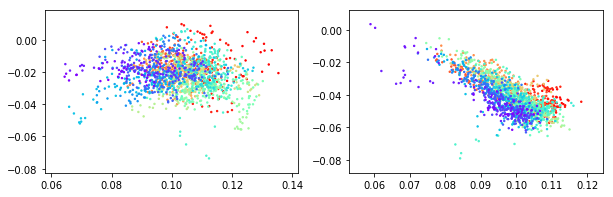

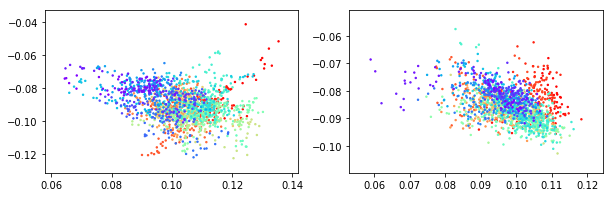

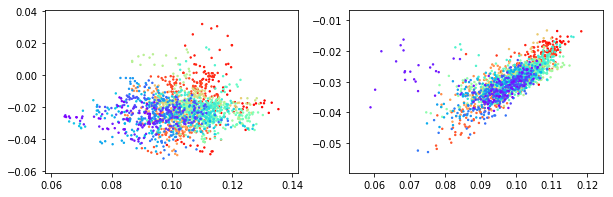

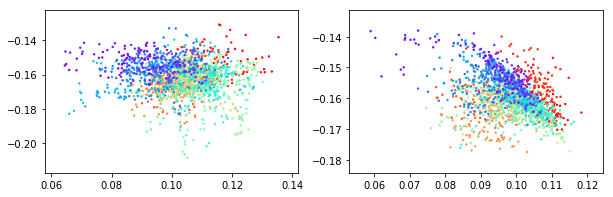

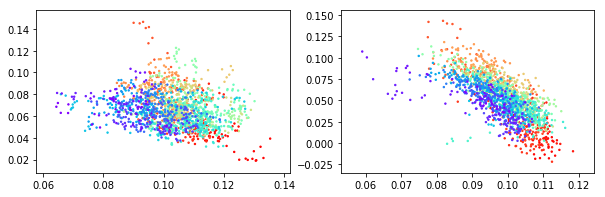

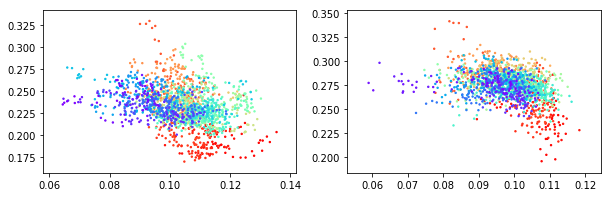

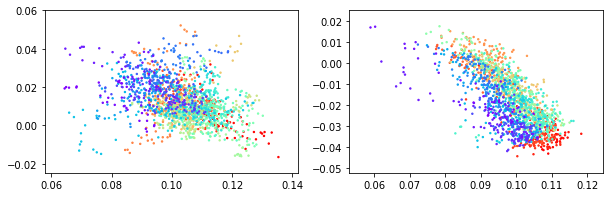

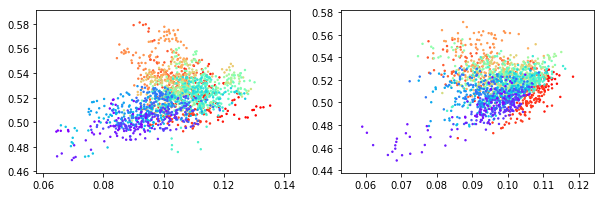

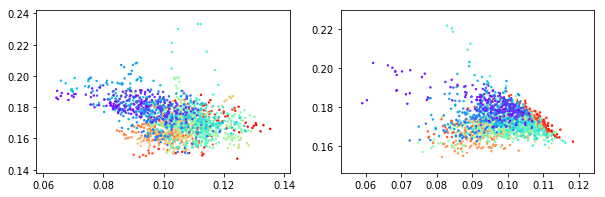

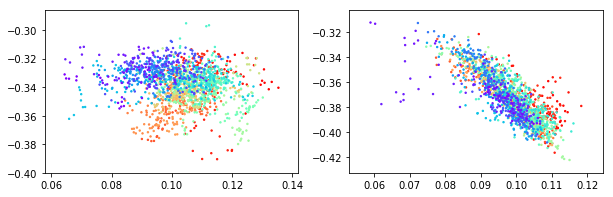

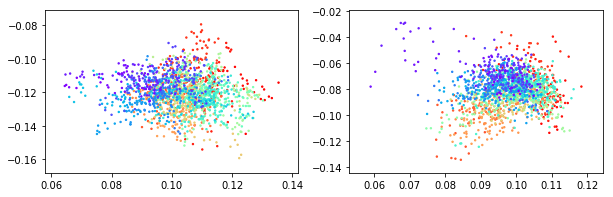

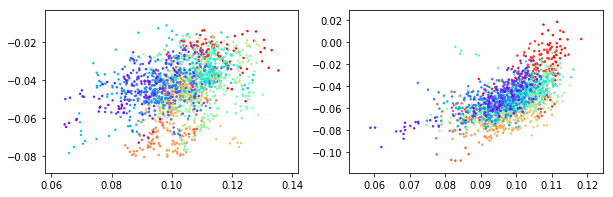

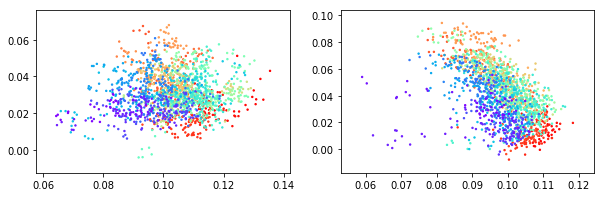

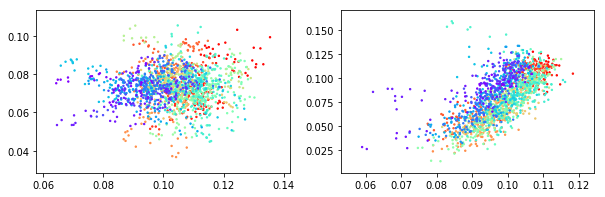

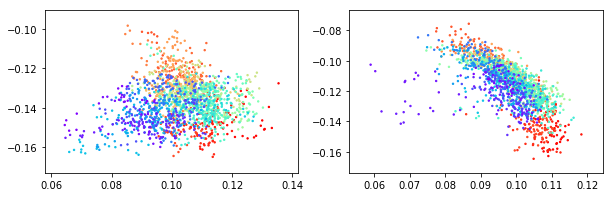

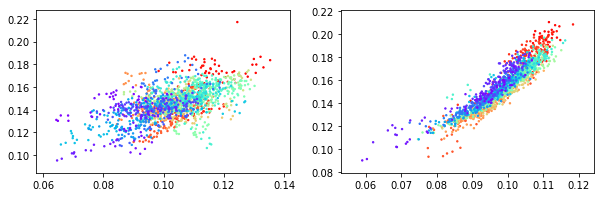

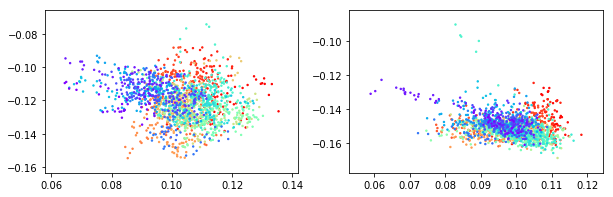

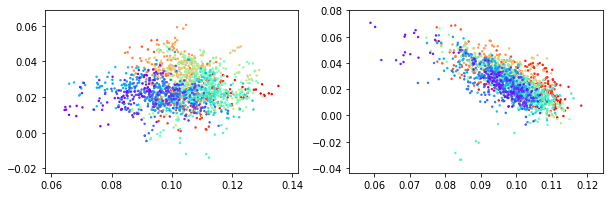

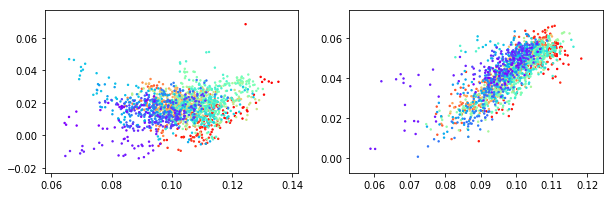

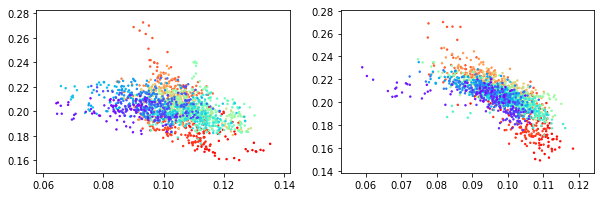

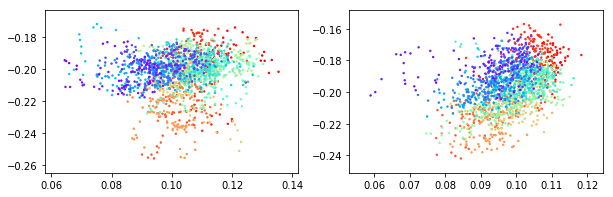

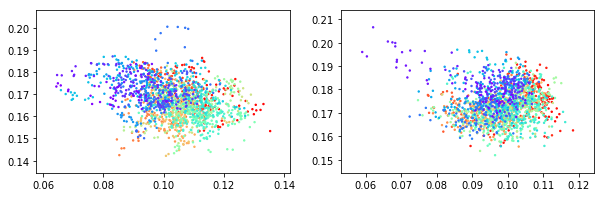

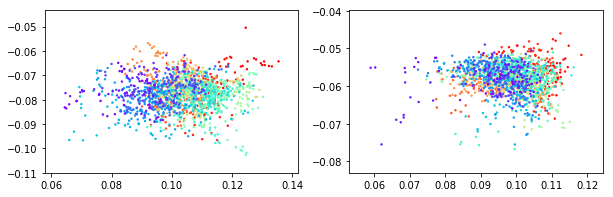

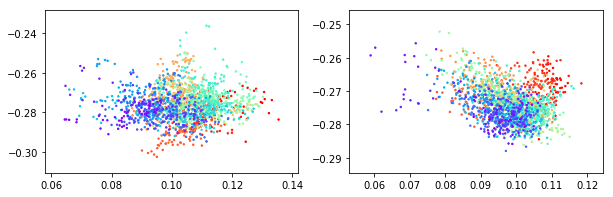

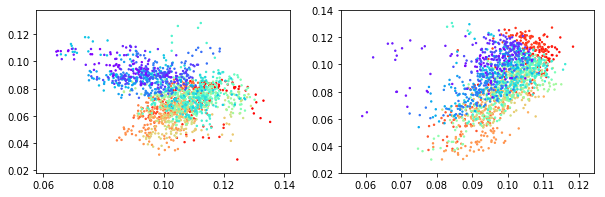

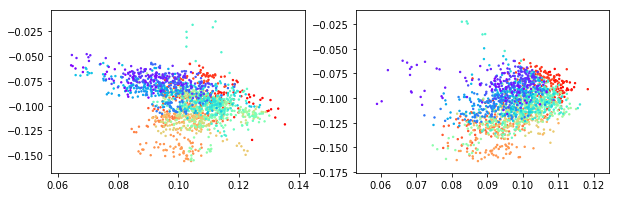

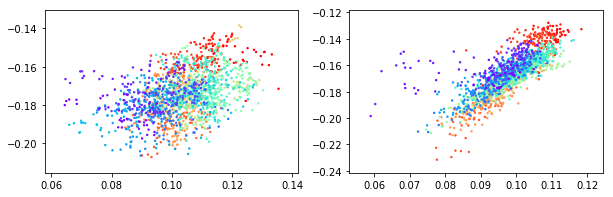

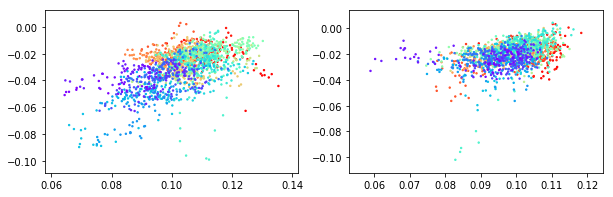

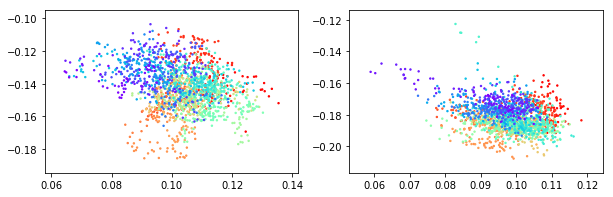

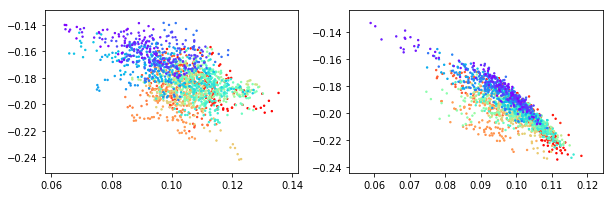

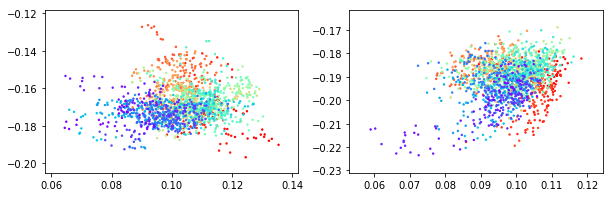

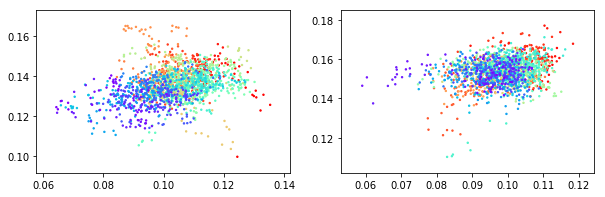

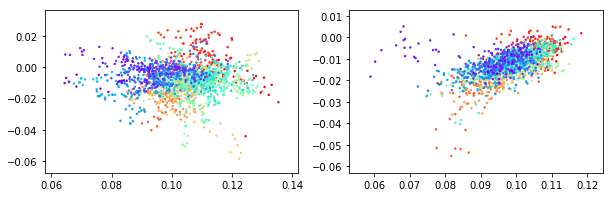

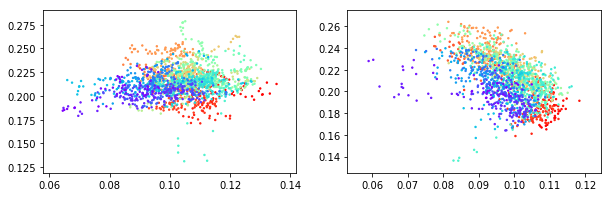

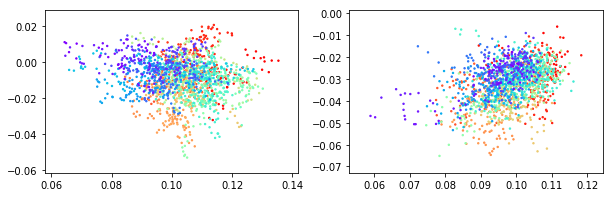

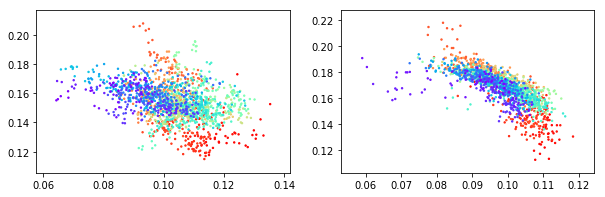

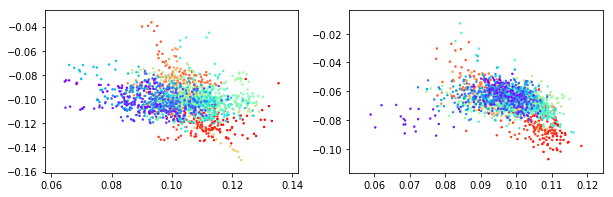

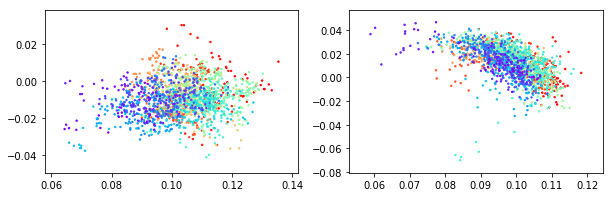

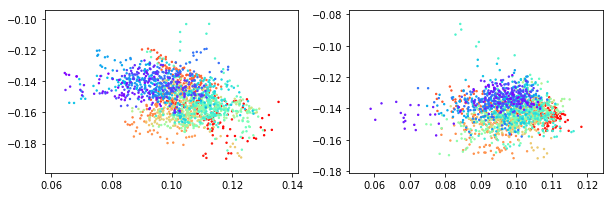

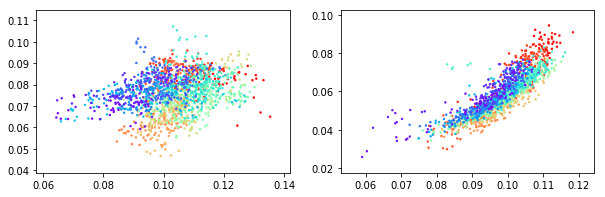

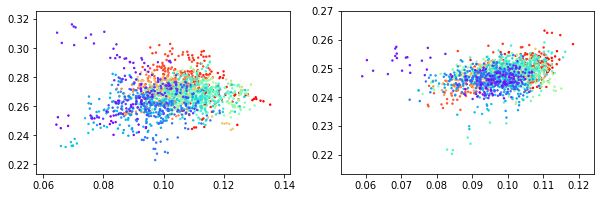

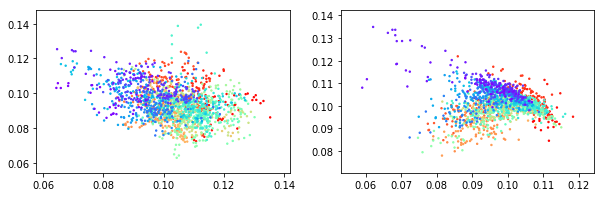

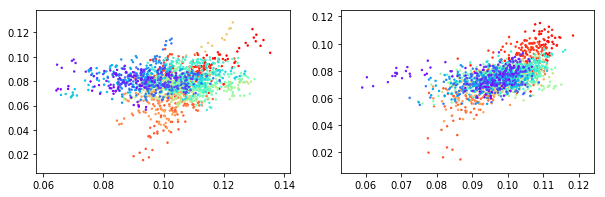

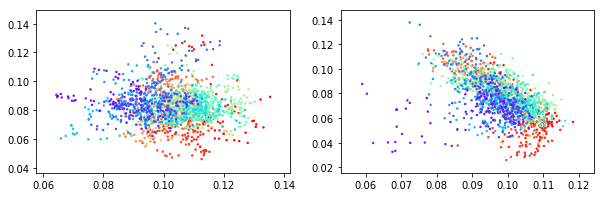

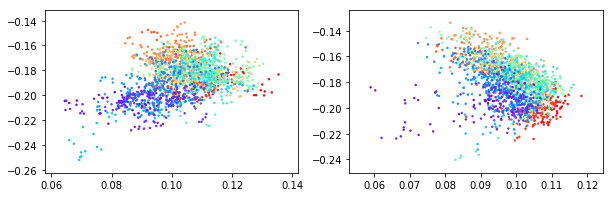

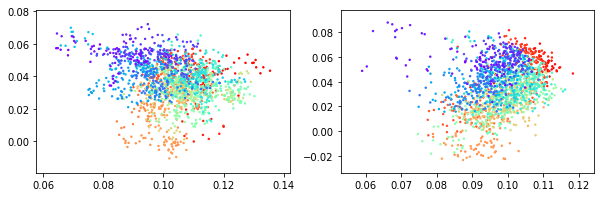

In [113]:
axis_1 = 1
axis_2 = 80

before = list(new_df.avg_embed_log)
after = model.reconstructor(before)

colors = cm.rainbow(np.linspace(1, 0, len(new_df)))

for axis_2 in range(1,100):
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    x1 = np.array(list(before))[:,axis_1]
    y1 = np.array(list(before))[:,axis_2]
    x2 = np.array(list(after))[:,axis_1]
    y2 = np.array(list(after))[:,axis_2]

    ax[0].scatter(x1, y1, color=colors, s=2)
    ax[1].scatter(x2, y2, color=colors, s=2)
    plt.show()

In [28]:
total_data = load_obj('upper1')
phraser = PhraserModel().get_phraser
dic = KeywordDict(phraser=phraser).get_dict
tfidf = Model(dic, name='bpc', smartirs='bpc', phraser=phraser).get_model
embedding = EmbeddingModel().get_embedding

In [116]:
def title_embed(title):
    keywords = words2keywords(title)
    if len(keywords)==0:
        return []
    words, idf_scores = zip(*keywords)
    idf_scores = idf_scores/sum(idf_scores)

    avg_embedding = np.zeros(100, dtype=np.float32)
    for idx in range(len(words)):
        word = words[idx]
        embedding_vec = embedding[word]
        idf = idf_scores[idx]
        avg_embedding += idf*embedding_vec

    return avg_embedding

def sentence2keywords(title, topn=None):
    splitted = phraser[tokenizer([clean(title)])]
    scores = tfidf[dic.doc2bow(splitted[0])]
    keyword = []
    for idx, score in scores:
        keyword.append((tfidf.id2word[idx], score))
    keyword.sort(key=lambda k: k[1], reverse=True)
    
    if topn!=None:
        return keyword[:topn]
    else:
        return keyword

def words2keywords(words, topn=None):
    scores = tfidf[dic.doc2bow(words)]
    keyword = []
    for idx, score in scores:
        keyword.append((tfidf.id2word[idx], score))
    keyword.sort(key=lambda k: k[1], reverse=True)
    
    if topn!=None:
        return keyword[:topn]
    else:
        return keyword

In [38]:
total_data = total_data.reset_index(drop=True)

In [117]:
def inbound(target, vec_list, threshold, beta=50):
    return [np.sqrt(sum((target - vec)**2)) + beta * abs(spatial.distance.cosine(target, vec)) < threshold for vec in vec_list]

def distance(vec1, vec2):
    return np.sqrt(sum((vec1 - vec2)**2))

def similarity(vec1, vec2):
    #return cosine_similarity([target for i in range(len(vec_list))], vec_list)
    #return [cosine_similarity([target], [vec]) for vec in vec_list]
    return spatial.distance.cosine(vec1, vec2)

In [63]:
similarity(title_embed(total_data.lemmatized[5]), title_embed(total_data.lemmatized[3]))

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


0.24775969982147217

In [118]:
def recon_embed(title):
    embed = title_embed(list(title))
    if len(embed)==0:
        return
    return model.reconstructor([embed])[0]

In [106]:
embed_data = load_obj('embedding_data')

In [108]:
recon_list = model.reconstructor(embed_data)

In [131]:
total_data[total_data.lemmatized.apply(len)>30]

date  score                                              title  \
2082    2017-11-07     14  panic grips delhi india as residents woke up t...   
2648    2017-11-09     11  german court hands suspended sentence to swiss...   
2880    2017-11-10      7  uks biggest solar farm planned for kent coast ...   
3273    2017-11-11      8  germanys eu bill to rise by percent post brexi...   
4168    2017-11-14      3  age of non consent on trial in france amid con...   
6037    2017-11-19      3  china military sets up website to report leaks...   
7234    2017-11-22     34  canadas long awaited federal housing strategy ...   
8235    2017-11-25    425  german christmas markets city protects pedestr...   
8514    2017-11-26    652  environmental crime threatens europes last pri...   
8670    2017-11-27    482  spaniards face ham shortage as chinese market ...   
10601   2017-12-02    235  law in hong kong doesnt protect children from ...   
10937   2017-12-04      2  by arresting darfurs powerful militia chief mu...   
13079   2017-12-10     19  japan u s south korea to hold missile tracking...   
13605   2017-12-12     32  scientists have unveiled detailed genetic map ...   
13901   2017-12-13      8  russian national security concerns are casting...   
14827   2017-12-16     21  ethiopian ex official gets dutch life sentence...   
15323   2017-12-18     16  putin called president trump to thank cia for ...   
15806   2017-12-19     10  one million children living in poverty will mi...   
17175   2017-12-24      8  no place for turkish climate of fear in german...   
17706   2017-12-26     10  russian deputy pm quits football role before w...   
17709   2017-12-26      5  germanys sigmar gabriel brexit deal could serv...   
17769   2017-12-26   1108  japan pm abe urges firms to raise wages by per...   
18272   2017-12-28   1203  airlines cant blame computer models for higher...   
18701   2017-12-30     11  new study shows afd facebook posts spur anti r...   
19020   2017-12-31     17  fdp leader wants germany to deport minor refug...   
19023   2017-12-31     98  ticket touts will be banned from using automat...   
19575   2018-01-02    441  australian paedophiles hoping to stay under ra...   
20195   2018-01-04      7  poo tracker new zealand website reveals sewage...   
20277   2018-01-04    259  poo tracker new zealand website reveals sewage...   
20797   2018-01-06     26  murder of lawyer iryna nozdrovska shakes ukrai...   
...            ...    ...                                                ...   
501461  2014-12-22     26  tiger amp wild cat trade from myanmar to china...   
502003  2014-12-23     22  a new way to reach mars safely anytime and on ...   
502617  2014-12-24    500  oldest recorded stone tool ever found in turke...   
508959  2014-09-29     22  death hunger stalk indian tea workers closing ...   
509886  2015-03-02     27  estonias ruling pro nato center right claims e...   
514348  2015-03-14    525  new draft policy to increase japans flagging b...   
514459  2015-03-15      6  syriza natural gas strategy main target is to ...   
519973  2014-02-02    262  beijing smog contains witches brew of microbes...   
521805  2014-03-04      7  russia demands ukraine warships surrender four...   
525208  2014-02-09     13  british communities secretary eric pickles apo...   
525362  2014-02-10     50  nick clegg has dragged the case for reforming ...   
528391  2014-03-13      4  a court in india has upheld the death sentence...   
530096  2015-06-02      2  russia china joint sea drills show high level ...   
534811  2014-03-21     10  ukrainian nationalists hand russians propagand...   
535033  2015-06-05      4  air strike in north iraq killed dozens includi...   
535536  2015-06-05     45  high level international body led by kofi anna...   
537547  2014-02-25      2  kim yuna and the korean art of suffering olymp...   
537828  2015-06-06   3554  faith leaders to obama give women raped by isi...   
539206  2015-0

In [110]:
print(embed_data.shape)
print(recon_list.shape)

(557031, 100)
(557031, 100)


In [119]:
title = total_data.lemmatized[0]
embed = title_embed(title)
recon = model.reconstructor([embed])[0]
print(title)
print()
print(embedding.similar_by_vector(title_embed(title)))
print()
print(embedding.similar_by_vector(recon))
print()
print(distance(embed, recon))
print(similarity(embed, recon))

['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']

[('organize', 0.8307799100875854), ('socialize', 0.7752810716629028), ('invite', 0.7675635814666748), ('friend', 0.7585570216178894), ('listen', 0.7580553293228149), ('imagine', 0.7517143487930298), ('personally', 0.7458996176719666), ('remind', 0.7431463599205017), ('person', 0.7408796548843384), ('empower', 0.7408207654953003)]

[('insist', 0.7829802632331848), ('invite', 0.7712976932525635), ('politician', 0.7702864408493042), ('friend', 0.765694797039032), ('hate', 0.7623828649520874), ('complain', 0.7606439590454102), ('imagine', 0.7527828812599182), ('remind', 0.7517087459564209), ('slobbering', 0.749610960483551), ('refuse', 0.7460017204284668)]

0.7835005246892567
0.12378877401351929


/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


0.8112513274163293
